In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Supersimple game:
Given a state as a vector the AI has to learn to play over 0 value.

In [252]:
# Definition of the reward function in the game:
def reward_func(state, action):
    # State is a vector and action an index 
    # with the position of the state over which to play:
    next_state = np.empty_like(state)
    next_state[:] = state
    if next_state[action] == 0:
        next_state[action] = 1
        return next_state, +1
    else:
        return next_state, -1

In [253]:
## Check the game is working properly.
#for i in range(10):
#    state = np.random.randint(0, high=2, size=5)
#    print(state)
#    ind = np.random.randint(0,high=5)
#    next_state, reward = reward_func(state, ind)
#    print(ind, state, next_state, reward)

# Agent settings

In [254]:
# Definition of neural net:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, D_in, H1, H2, D_out):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(D_in, H1)
        self.lin2 = nn.Linear(H1, H2)
        self.lin3 = nn.Linear(H2, D_out)
        self.transfer = nn.ReLU()

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [255]:
from collections import namedtuple
import random
# Define replay memory:
Transition = namedtuple('Transition',\
        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def add(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch):
        return random.sample(self.memory, batch)

    def __len__(self):
        return len(self.memory)

In [256]:
def optimize(policy, target, memory, BATCH, optimizer):
    if memory.__len__() < BATCH:
        return
    
    transitions = memory.sample(BATCH)
    batch = Transition(*zip(*transitions))
    
    # Separate states, rewards,...
    states = torch.cat(batch.state).reshape(BATCH, -1)
    actions = torch.cat(batch.action)
    rewards = torch.cat(batch.reward)
    next_state = torch.cat(batch.next_state).reshape(BATCH, -1)
    
    # Evaluate policy on states:
    out_policy = policy(states).gather(1, actions)
    
    # Evaluate target:
    out_target = target(next_state).max(1)[0]
    
    for elem in range(out_target.size(0)):
        if torch.sum(next_state[elem,:]==5): out_target *= 0.
    
    target = (rewards + GAMMA * out_target).view(BATCH,1)
    loss = torch.mean(torch.pow(out_policy - target,2))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy.parameters():
        param.grad.data.clamp_(-1, 1)
     
    optimizer.step()
    return loss.item()

In [300]:
CAPACITY = 10000
BATCH = 100
EPISODES = 2000
GAMMA = 0.99
UPDATE = 200
IT_PRINT = 100

In [301]:
EPS = 5e-2
def select_move(policy, state):
    if random.random() < EPS:
        return torch.randint(0,5,(1,1))
    else:
        policy_value = policy(torch.Tensor(state))
        return policy_value.max(0)[1].view(1,1)

In [302]:
# Define policy and target functions.
policy = DQN(5,15,15,5)
target = DQN(5,15,15,5)
target.load_state_dict(policy.state_dict())
target.eval()

# Declare optimizer:
optimizer = torch.optim.RMSprop(policy.parameters(), lr=0.0025)

In [303]:
from IPython.display import clear_output

# Initialize replaymemory.
replaymemory = ReplayMemory(CAPACITY)

loss_list, reward_list = [], []
epoch = 0
# Start training loop:
for episode in range(EPISODES):
    state = np.random.randint(0, high=2, size=5)
    total_reward = 0
    while np.sum(state) < 5:
        # Pass state to agent to select a position to play:
        ind = select_move(policy, state)
        next_state, reward = reward_func(state,ind.item())
        
        total_reward += reward
        
        replaymemory.add(torch.Tensor(state),\
                         ind,\
                         torch.Tensor([reward]),\
                         torch.Tensor(next_state))
        
        if reward == -1:
            ind = torch.randint(0,5,(1,1))
            next_state, reward = reward_func(state,ind)
            total_reward += reward
            replaymemory.add(torch.Tensor(state),\
                         ind,\
                         torch.Tensor([reward]),\
                         torch.Tensor(next_state))
        
        
        state[:] = next_state
        #
        loss = optimize(policy, target, replaymemory, BATCH,optimizer)
        #
        if loss is not None and epoch %100 == 0:
            clear_output()
            print(epoch, loss, total_reward)
            loss_list.append(loss) 
            
        epoch += 1
    
        if epoch % UPDATE == 0:
            target.load_state_dict(policy.state_dict())
    
    reward_list.append(total_reward) 

5000 0.01303159724920988 2


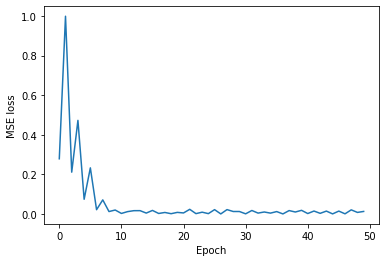

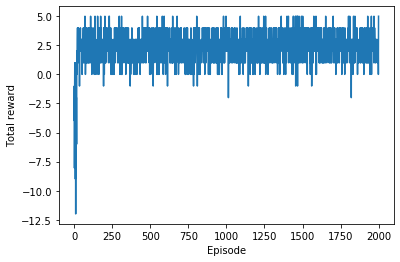

In [304]:
plt.plot(loss_list)
plt.ylabel('MSE loss')
plt.xlabel('Epoch')
plt.show()

# Total reward plot
plt.plot(reward_list)
plt.ylabel('Total reward')
plt.xlabel('Episode')
plt.show()

In [305]:
# Check for any posible position on board:
for i in range(2):
    for j in range(2):
        for k in range(2):
            for l in range(2):
                for m in range(2):
                    state = [i,j,k,l,m]
                    
                    if sum(state) < 5:
                        ind = select_move(policy, state)
                        _,good = reward_func(state,ind.item())
                        if good == 1:
                            good = True
                        else:
                            good = False
                        print(state, ind.item(), good)

[0, 0, 0, 0, 0] 2 True
[0, 0, 0, 0, 1] 1 True
[0, 0, 0, 1, 0] 1 True
[0, 0, 0, 1, 1] 1 True
[0, 0, 1, 0, 0] 1 True
[0, 0, 1, 0, 1] 1 True
[0, 0, 1, 1, 0] 1 True
[0, 0, 1, 1, 1] 1 True
[0, 1, 0, 0, 0] 4 True
[0, 1, 0, 0, 1] 3 True
[0, 1, 0, 1, 0] 4 True
[0, 1, 0, 1, 1] 0 True
[0, 1, 1, 0, 0] 3 True
[0, 1, 1, 0, 1] 0 True
[0, 1, 1, 1, 0] 4 True
[0, 1, 1, 1, 1] 0 True
[1, 0, 0, 0, 0] 1 True
[1, 0, 0, 0, 1] 1 True
[1, 0, 0, 1, 0] 1 True
[1, 0, 0, 1, 1] 1 True
[1, 0, 1, 0, 0] 4 True
[1, 0, 1, 0, 1] 1 True
[1, 0, 1, 1, 0] 4 True
[1, 0, 1, 1, 1] 1 True
[1, 1, 0, 0, 0] 4 True
[1, 1, 0, 0, 1] 3 True
[1, 1, 0, 1, 0] 4 True
[1, 1, 0, 1, 1] 2 True
[1, 1, 1, 0, 0] 4 True
[1, 1, 1, 0, 1] 3 True
[1, 1, 1, 1, 0] 4 True
